In [1]:
import os, glob, platform
import numpy as np
import numpy.matlib
import pickle
import pandas as pd
import pathlib
import matplotlib
import matplotlib.pyplot as plt

import mne
mne.__version__

'1.4.0'

In [7]:
import sys
path_utils = 'decoding_toolbox_py/helper_funcs' 
sys.path.append(path_utils)
import DecToolbox as dt


In [10]:
subjs_list = ['s01'
              #, 's02', 's03','s04','s05','s07','s08','s09','s10','s11','s12','s13','s14', 's15', 's16','s17','s18','s19','s20','s21','s22','s23','s24','s25','s26','s27' 
            ]
path = 'Cond_CJ_EEG'

In [11]:
epochs = []
for isubj, subject_id in enumerate(subjs_list):
    preproc_path = os.path.join(path, subject_id);
    epoch = mne.read_epochs(preproc_path + '/main_epo.fif',verbose=False)
    epochs.append(epoch.average());
    # print(isubj)

gvaverage = mne.grand_average(epochs[:])

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Identifying common channels ...


/var/folders/x2/l6kq7w2s48bbjcgczm1ll_fm0000gn/T/ipykernel_17464/4267958821.py:8: RuntimeWarning: Only a single dataset was passed to mne.grand_average().
  gvaverage = mne.grand_average(epochs[:])


In [12]:
all_st_epochs = []
all_st_rawdata = [None] * np.size(subjs_list)
for isubj, subject_id in enumerate(subjs_list):
    preproc_path = os.path.join(path, subject_id);
    epoch = mne.read_epochs(preproc_path + '/mainstim_epo.fif',verbose=False)
    subj_data = {'epoch_dat' : epoch.get_data(), 'metadata' :  epoch.metadata}
    all_st_rawdata[isubj] =  subj_data
    all_st_epochs.append(epoch);
    epoch.metadata

In [18]:
nSubj = np.size(subjs_list)

dec_subj = [None] * nSubj
G = [None] * nSubj

for ival, isubj in enumerate(subjs_list):
    print(ival)
    time = all_st_epochs[ival].times
    label = all_st_epochs[ival].ch_names
    Y = all_st_rawdata[ival]['epoch_dat']
    Y = np.einsum('kji->jik', Y)
    X = np.array(all_st_rawdata[ival]['metadata'].orient)
    phi = X
    #binned_phi = np.digitize(phi, bins = np.array([  0, 22.5, 45, 67.5, 90, 112.5, 135, 157.5 ]) ) # bins collapsing degrees by similarity
    binned_phi = np.digitize(phi, bins = np.array([  0, 45, 90, 135 ]) ) # bins collapsing degrees by similarity

    numF = Y.shape[0];
    numT = Y.shape[1];
    numN = Y.shape[2];
    numC = 8 # how many channels to use
    G[ival] = binned_phi.copy() # binning/discritizing orientation dimension to assign a balanced number of stimuli to different dat
    binned_phi = (G[ival]-1)*(180/4)
    
    CONDS = np.unique(G[ival])
    nConds = CONDS.size
    nfold = 4
    FoldsIdx = dt.CreateFolds(G[ival], Y, nfold)
    #numC = 8 # how many channels to use

    cfg = dict()
    cfg['kappa'] = 2
    cfg['NumC'] = numC
    cfg['Tuning'] = 'vonmises'#'halfRectCos'
    cfg['offset'] = 0

    design, sortedesign = dt.stim_features(binned_phi, cfg)
    
    
    # Xhat = np.zeros([numC,numN, numT])
    # for it in range(numT):
    #     cfg = dict()
    #     cfg['cfgE'] = {'gamma': 0.01, 'demean' : True, 'returnPattern' : True}
    #     cfg['cfgD'] = {'demean' : 'traindata'}
    #     Xhat[:,:,it] = dt.CV_encoder(design, Y, it, cfg, FoldsIdx)
    # 
    # dec_subj[ival] = Xhat   

0


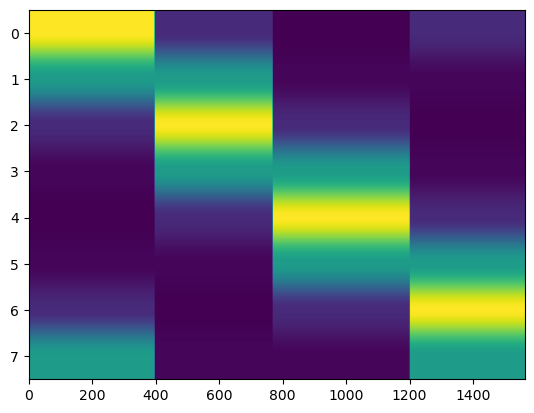

In [19]:
plt.imshow(sortedesign, aspect = 'auto')

In [23]:
print(np.shape(design), np.shape(Y[0]))

(8, 1563) (201, 1563)


In [24]:
cfg = dict()
cfg['gamma'] = 0.01
cfg['demean'] = True
cfg['returnPattern'] = True

# print(np.shape(design), np.shape(dat['Y_train']), np.shape(cfg))

# decoder = dt.train_encoder(design, dat['Y_train'], cfg)

decoder = dt.train_encoder(design, Y[0], cfg)

print(np.shape(decoder))

()


In [25]:
print(np.shape(X))

(1563,)


In [ ]:
cfg = dict()
cfg['demean'] = 'traindata'

Xhat = dt.test_encoder( decoder, da'], cfg)
